In [1]:
import torch.optim
import torchvision
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import (
    LearningRateMonitor,
)
from pytorch_lightning.loggers import MLFlowLogger
from data.coco import COCO2014
import albumentations as alb
from albumentations.pytorch import ToTensorV2

from models import ADD_GCN
from models.add_gcn_lightning import AddGcnModel
from data.coco_datamodule import CocoDataModule
from omegaconf import OmegaConf
from run_train import get_config_optim
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from PIL import Image
import os
from data import get_transform, MultiScaleCrop, collate_fn, DataLoader
import torchvision.transforms as transforms
import seaborn as sns
import cv2

In [2]:
params = OmegaConf.load('configs/train.yaml')

In [3]:
train_transform = alb.Compose([
    alb.RandomResizedCrop(448, 448, scale=(0.1, 1.5), ratio=(1.0, 1.0)),
    alb.HorizontalFlip(),
    alb.Normalize(always_apply=True, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = alb.Compose([
    alb.Resize(448, 448),
    alb.Normalize(always_apply=True, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

train_transform_old = get_transform(image_size=448, is_train=True)

In [4]:
train_dataset = COCO2014('dataset/COCO2014', train_transform_old, phase='train', filter_labels=params.dataset.filter_labels)

val_dataset = COCO2014('dataset/COCO2014', val_transform, phase='val', filter_labels=params.dataset.filter_labels)

data_module = CocoDataModule(
    train_dataset,
    val_dataset,
    batch_size=16,
    num_workers=8,
)

[dataset] COCO2014 classification phase=train number of classes=80  number of images=82081
[dataset] COCO2014 classification phase=val number of classes=80  number of images=40137


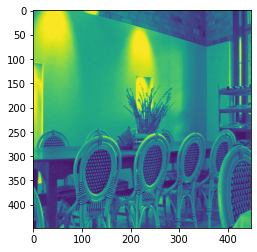

In [5]:
# plt.imshow(train_dataset[0][0].permute(1, 2, 0))
# plt.show()
plt.imshow(train_dataset[0][0][0])
plt.show()

In [6]:
labels = [str(x['labels']) for x in train_dataset.img_list]

In [7]:
architecture = ADD_GCN(
    torchvision.models.resnet101(pretrained=True),
    train_dataset.num_classes
)

# model = AddGcnModel.load_from_checkpoint('run/2021-12-04/13-09-55_coco_training/checkpoint/ckp_epoch=26-step=34640-val_loss=0.049.ckpt', architecture=architecture)
model = AddGcnModel.load_from_checkpoint('run/2021-11-28/11-37-52_coco_training/checkpoint/ckp_epoch=33-step=43621-val_loss=0.041.ckpt', architecture=architecture)
state_dict = torch.load('run/best_model.pt')
model.model.load_state_dict(state_dict['state_dict'])
model = model.eval()

/home/lmammana/vision2/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


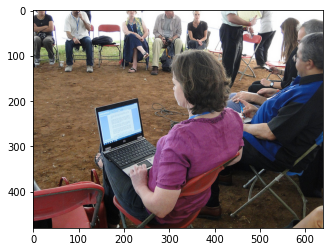

tensor([[-0.2692, -0.6426,  1.9041,  5.9832,  3.0001]])
tensor([[-3.7023, -3.1312, 30.6778, 14.1752, 65.3210]])
tensor([0.1207, 0.1316, 1.0000, 1.0000, 1.0000])
Groundtruth: ['backpack', 'cell phone', 'chair', 'laptop', 'person']
Predictions: ['chair', 'laptop', 'person']


In [96]:
input_idx = np.random.randint(0, len(val_dataset))
input_img = val_dataset[input_idx][0]
gt = val_dataset[input_idx][1]

idx2cat = {v: k for k, v in train_dataset.cat2idx.items()}
with torch.no_grad():
    s_m, s_r, adj_mat = model(input_img.unsqueeze(0))

adj_mat = adj_mat.squeeze().numpy()
# s_m = torch.sigmoid(s_m)
# s_r = torch.sigmoid(s_r)

output = ((s_m + s_r) / 2).squeeze()
output = torch.sigmoid(output)
output_th = (output > 0.5).to(torch.int64).numpy()

input_img = Image.open(os.path.join(val_dataset.root, 'val2014', val_dataset.img_list[input_idx]['file_name']))
plt.imshow(input_img)
plt.show()

idx_gt_labels = np.where(gt == 1)[0]
idx_predicted_labels = np.where(output_th == 1)[0]

print(s_m[:, idx_gt_labels])
print(s_r[:, idx_gt_labels])
print(output[idx_gt_labels])
gt_labels = [idx2cat.get(label) for label in idx_gt_labels]
predicted_labels = [idx2cat.get(label) for label in idx_predicted_labels]

print(f"Groundtruth: {gt_labels}")
print(f"Predictions: {predicted_labels}")

In [8]:
plot = sns.heatmap(adj_mat[idx_gt_labels, :], xticklabels=gt_labels, yticklabels=gt_labels, cmap='jet')

plot.figure.savefig('dynamic_adj_coco.png')

NameError: name 'adj_mat' is not defined

In [80]:
idx_gt_labels

adj_mat[12, 51]

0.0098450165

In [14]:
adj_mat.numpy().shape

(1, 80, 80)

In [9]:
trainer = Trainer(gpus=[0], precision=16, logger=False, enable_checkpointing=False)

predictions = trainer.predict(model, data_module.val_dataloader())

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: 0it [00:00, ?it/s]

/home/lmammana/vision2/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:172: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


In [10]:
pred = torch.cat([torch.sigmoid(el[0]) for el in predictions])
y = torch.cat([el[1] for el in predictions])

In [11]:
from torchmetrics import F1, AveragePrecision

f1 = F1(num_classes=y.shape[1], average='macro', threshold=0.5)
ap = AveragePrecision(num_classes=y.shape[1], average='macro')

In [12]:
f1_score = f1(pred, y)
ap_score = ap(pred, y)

In [13]:
print(f1_score)
print(ap_score)

tensor(0.7843)
tensor(0.8417)


In [6]:
static_adj_matrix = list(model.model.gcn.static_adj[0].parameters())[0].detach().numpy().squeeze()

In [10]:
import cv2

cv2.imwrite('static_adj_coco.png', static_adj_matrix)

True

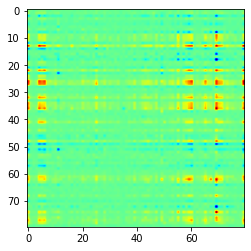

In [7]:
plt.imshow(static_adj_matrix, cmap='jet')

<Figure size 1368x1080 with 0 Axes>

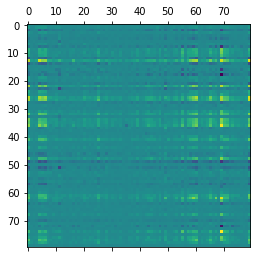

In [12]:
f = plt.figure(figsize=(19, 15))
plt.matshow(static_adj_matrix)

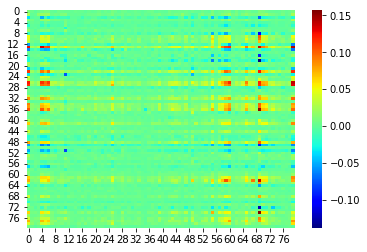

In [15]:
plot = sns.heatmap(static_adj_matrix, cmap='jet')

plot.figure.savefig('static_adj_coco.png')

In [28]:
np.where(static_adj_matrix > 0.138)

(array([13, 26, 36, 62, 74]), array([79, 79, 69, 69, 69]))

In [39]:
static_adj_matrix[74, 69]

0.1566429

In [40]:
print(idx2cat[74])
print(idx2cat[69])

truck
toaster


In [38]:
idx2cat

{0: 'airplane',
 1: 'apple',
 2: 'backpack',
 3: 'banana',
 4: 'baseball bat',
 5: 'baseball glove',
 6: 'bear',
 7: 'bed',
 8: 'bench',
 9: 'bicycle',
 10: 'bird',
 11: 'boat',
 12: 'book',
 13: 'bottle',
 14: 'bowl',
 15: 'broccoli',
 16: 'bus',
 17: 'cake',
 18: 'car',
 19: 'carrot',
 20: 'cat',
 21: 'cell phone',
 22: 'chair',
 23: 'clock',
 24: 'couch',
 25: 'cow',
 26: 'cup',
 27: 'dining table',
 28: 'dog',
 29: 'donut',
 30: 'elephant',
 31: 'fire hydrant',
 32: 'fork',
 33: 'frisbee',
 34: 'giraffe',
 35: 'hair drier',
 36: 'handbag',
 37: 'horse',
 38: 'hot dog',
 39: 'keyboard',
 40: 'kite',
 41: 'knife',
 42: 'laptop',
 43: 'microwave',
 44: 'motorcycle',
 45: 'mouse',
 46: 'orange',
 47: 'oven',
 48: 'parking meter',
 49: 'person',
 50: 'pizza',
 51: 'potted plant',
 52: 'refrigerator',
 53: 'remote',
 54: 'sandwich',
 55: 'scissors',
 56: 'sheep',
 57: 'sink',
 58: 'skateboard',
 59: 'skis',
 60: 'snowboard',
 61: 'spoon',
 62: 'sports ball',
 63: 'stop sign',
 64: 'suitc